# SVM을 이용한 농구선수 포지션 분석하기

## SVM 알고리즘 요약

In [ ]:
# 분류를 통한 분석 모듈 호출 : 지도 학습(데이터 + 정답)
from sklearn import svm, metrics

# 학습용 데이터, 학습용 정답, 테스트용 데이터, 테스트용 정답의 4개 데이터를 자동분류함
from sklearn.model_selection import train_test_split

# 데이터 전처리 -> 학습용 데이터, 학습용 정답, 테스트용 데이터, 테스트용 정답

# 학습용 데이터   ->   train_data   ---->   X_train
# 학습용 정답     ->   train_label  ---->   y_train
# 테스트용 데이터 ->   test_data    ---->   X_test
# 테스트용 정답   ->   test_label   ---->   y_test

# 분류 알고리즘 중에서 서포트벡터머신의 SVC 알고리즘을 학습기로 선택
clf = svm.SVC()

# 머신러닝
clf.fit(학습용 데이터, 학습용 데이터의 정답)

# 학습시키지 않은 데이터를 이용하여 질문(예측한다)
predict = clf.predict(테스트용 데이터)
print('예측 결과 :', predict)

# 예측한 결과의 정확도 계산 , 근거제시에 이용, 중요!!
score = metrics.accuracy_score(예측값:predict, 테스트용 데이터의 정답)
print('예측 정확도:', score)

### 예) SVM을 이용한 AND 연산 분석하기 : 둘다 참(1)인 경우에만 참(1)이 된다.

In [7]:
# 1. 모듈 선언
from sklearn import svm, metrics

# 2. 데이터 전처리 : 4개의 데이터를 분류하는 과정
train_data = [[0,0],[0,1],[1,0],[1,1]]
train_label = [0,0,0,1]
test_data = [[1,0],[1,1]]
test_label = [0,1]

# 3. 머신 러닝
clf = svm.SVC()

clf.fit(train_data, train_label)

predict = clf.predict(test_data)
print('예측 결과 :', predict)

score = metrics.accuracy_score(predict, test_label)
print('예측 정확도:', score)

예측 결과 : [0 1]
예측 정확도: 1.0


## 1. 라이브러리 호출

In [8]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 경고창 무시
import warnings
warnings.filterwarnings(action = 'ignore')

## 2. 데이터 준비 (미리 나눠놓았던 데이터)

In [16]:
with open('basketball_train.pkl','rb') as train_data:
    train = pickle.load(train_data)
    
with open('basketball_test.pkl','rb') as test_data:
    test = pickle.load(test_data)

#### 최적의 비용(cost)과 감마값(gamma)을 구한다.

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import numpy as np

In [21]:
# 최적의 비용과 감마값을 구하는 함수 생성

def svc_param_selection(X, y, nfolds) :
    svm_parameters = [
        {'kernel' : ['rbf'],
        'gamma' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1], # 감마
        'C' : [0.01, 0.1, 1, 10, 100, 1000]}              # 비용
    ]
    
    # 사이킷런에서 제공하는 그리디서치를 이용하여 최적의 파라미터(값)를 구한다.
    clf = GridSearchCV(SVC(), svm_parameters, cv = 10)
    clf.fit(X_train, y_train.values.ravel())
    print(clf.best_params_)
    
    return clf

## 3. 데이터 분류
- 3점슛과 블로킹 횟수를 학습용 데이터로 지정
- 선수 포지션을 테스트용 데이터로 지정

In [25]:
X_train = train[['3P','BLK']]
y_train = train[['Pos']]

#### 최적의 파라미터로 학습된 모델을 clf 변수에 저장

In [26]:
clf = svc_param_selection(X_train, y_train.values.ravel(), 10)

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


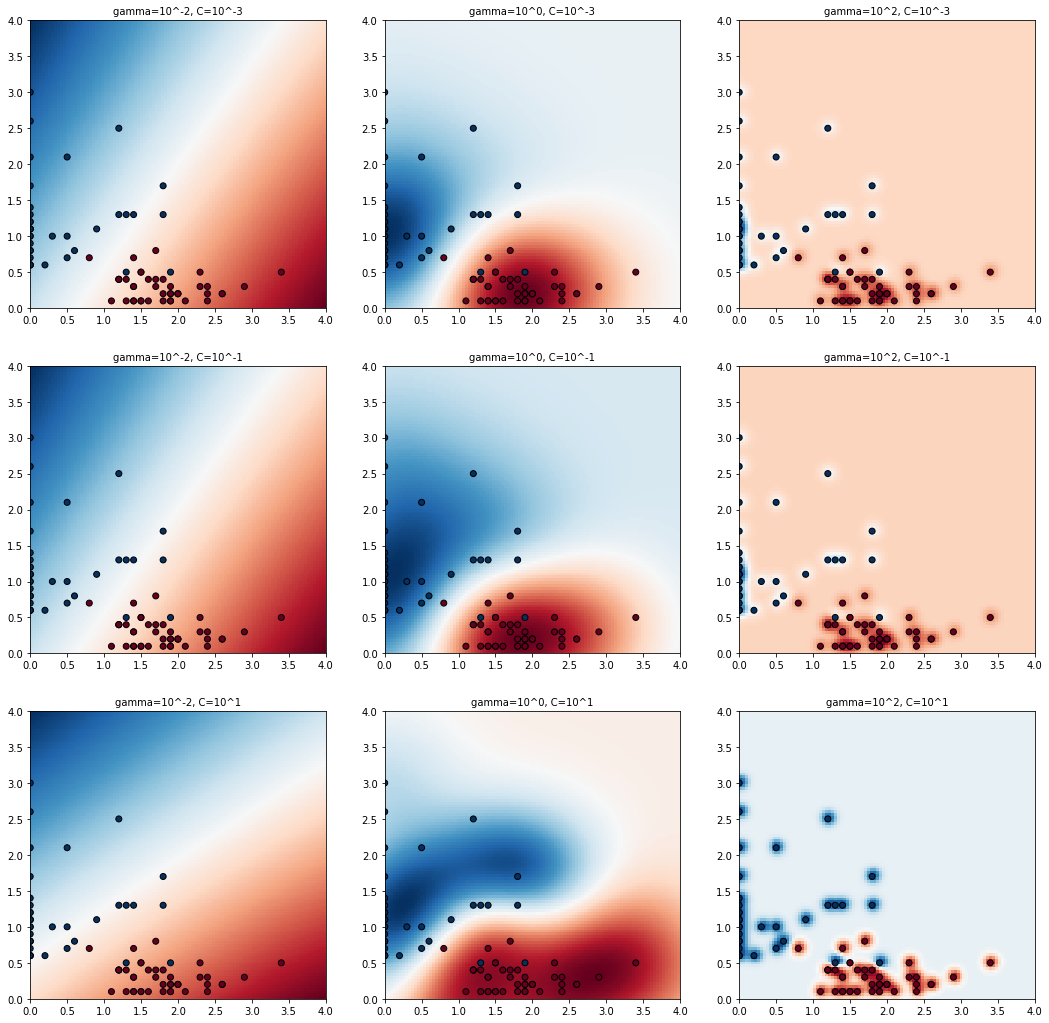

In [27]:
# 시각화할 비용 후보들을 저장합니다.
C_canditates = []
C_canditates.append(clf.best_params_['C'] * 0.01)
C_canditates.append(clf.best_params_['C'])
C_canditates.append(clf.best_params_['C'] * 100)


# 시각화할 다른 gamma를 후보로 저장합니다.
gamma_candidates = []
gamma_candidates.append(clf.best_params_['gamma'] * 0.01)
gamma_candidates.append(clf.best_params_['gamma'])
gamma_candidates.append(clf.best_params_['gamma'] * 100)


# 3점슛과 블록킹 횟수로 학습
X = train[['3P', 'BLK']]

# 농구선수 포지션을 학습 모델의 분류값으로 사용
Y = train['Pos'].tolist()


# 포지션에 해당하는 문자열 SG와 C를 벡터화합니다.
position = []
for gt in Y:
    if gt == 'C':
        position.append(0)
    else:
        position.append(1)

# 각각의 파라미터에 해당하는 SVM 모델을 만들어 classifiers에 저장합니다.
classifiers = []
for C in C_canditates:
    for gamma in gamma_candidates:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X, Y)
        classifiers.append((C, gamma, clf))


# 18,18 사이즈의 챠트를 구성합니다.
plt.figure(figsize=(18, 18))
xx, yy = np.meshgrid(np.linspace(0, 4, 100), np.linspace(0, 4, 100))


# 각각의 모델들에 대한 결정 경계 함수를 적용하여 함께 시각화합니다.
for (k, (C, gamma, clf)) in enumerate(classifiers):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # 최적의 모델을 포함한 다른 파라미터로 학습된 모델들을 함께 시각화해봅니다.
    plt.subplot(len(C_canditates), len(gamma_candidates), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # 서포트 벡터와 결정경계선을 시각화합니다.
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X['3P'], X['BLK'], c=position, cmap=plt.cm.RdBu_r, edgecolors='k')


## 4. 선수 포지션 데이터를 가지고 실제 예측 수행

In [30]:
X_test = test[['3P','BLK']]

y_test = test[['Pos']]

y_true, y_predict = y_test, clf.predict(X_test)

print('정확도 : ' + str(accuracy_score(y_true, y_predict)))
print()
print(classification_report(y_true, y_predict))

정확도 : 0.95

              precision    recall  f1-score   support

           C       1.00      0.91      0.95        11
          SG       0.90      1.00      0.95         9

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20



## 5. 실제값과 예측값 비교 출력

In [31]:
comparison = pd.DataFrame({'prediction': y_predict,
                          'ground_truth' : y_true.values.ravel()}) 
comparison

,prediction,ground_truth
0,C,C
1,SG,SG
2,C,C
3,SG,SG
4,C,C
5,C,C
6,C,C
7,SG,SG
8,SG,SG
9,C,C


In [32]:
comparison = pd.DataFrame({'예측값': y_predict,
                          '실제값' : y_true.values.ravel()}) 
comparison

,예측값,실제값
0,C,C
1,SG,SG
2,C,C
3,SG,SG
4,C,C
5,C,C
6,C,C
7,SG,SG
8,SG,SG
9,C,C
